### Import Resources

In [267]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
    
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.19.0
	• GPU device not found. Running on CPU


### Load MNIST dataset

In [268]:
dataset, dataset_info = tfds.load('mnist', split=['train', 'test'], as_supervised = True, with_info = True)

training_set, testing_set = dataset

### Explore the dataset

In [269]:
total_examples = dataset_info.splits['train'].num_examples + dataset_info.splits['test'].num_examples

num_training_examples = dataset_info.splits['train'].num_examples
num_test_examples = dataset_info.splits['test'].num_examples

print(f'There are {num_training_examples:,} images in the training set')
print(f'There are {num_test_examples:,} images in the test set')

There are 60,000 images in the training set
There are 10,000 images in the test set


### Define the pipeline

In [270]:
image_size = 28

def normalize(image, label):
    image = tf.cast(image, tf.float32)
    #image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    #image = image >=32
    return image, label

batch_size = 64

training_batches = training_set.cache().shuffle(num_training_examples//4).batch(batch_size).map(normalize).prefetch(1)
testing_batches = testing_set.cache().map(normalize).batch(batch_size).prefetch(1)

2025-05-24 03:13:23.948526: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-24 03:13:23.948575: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


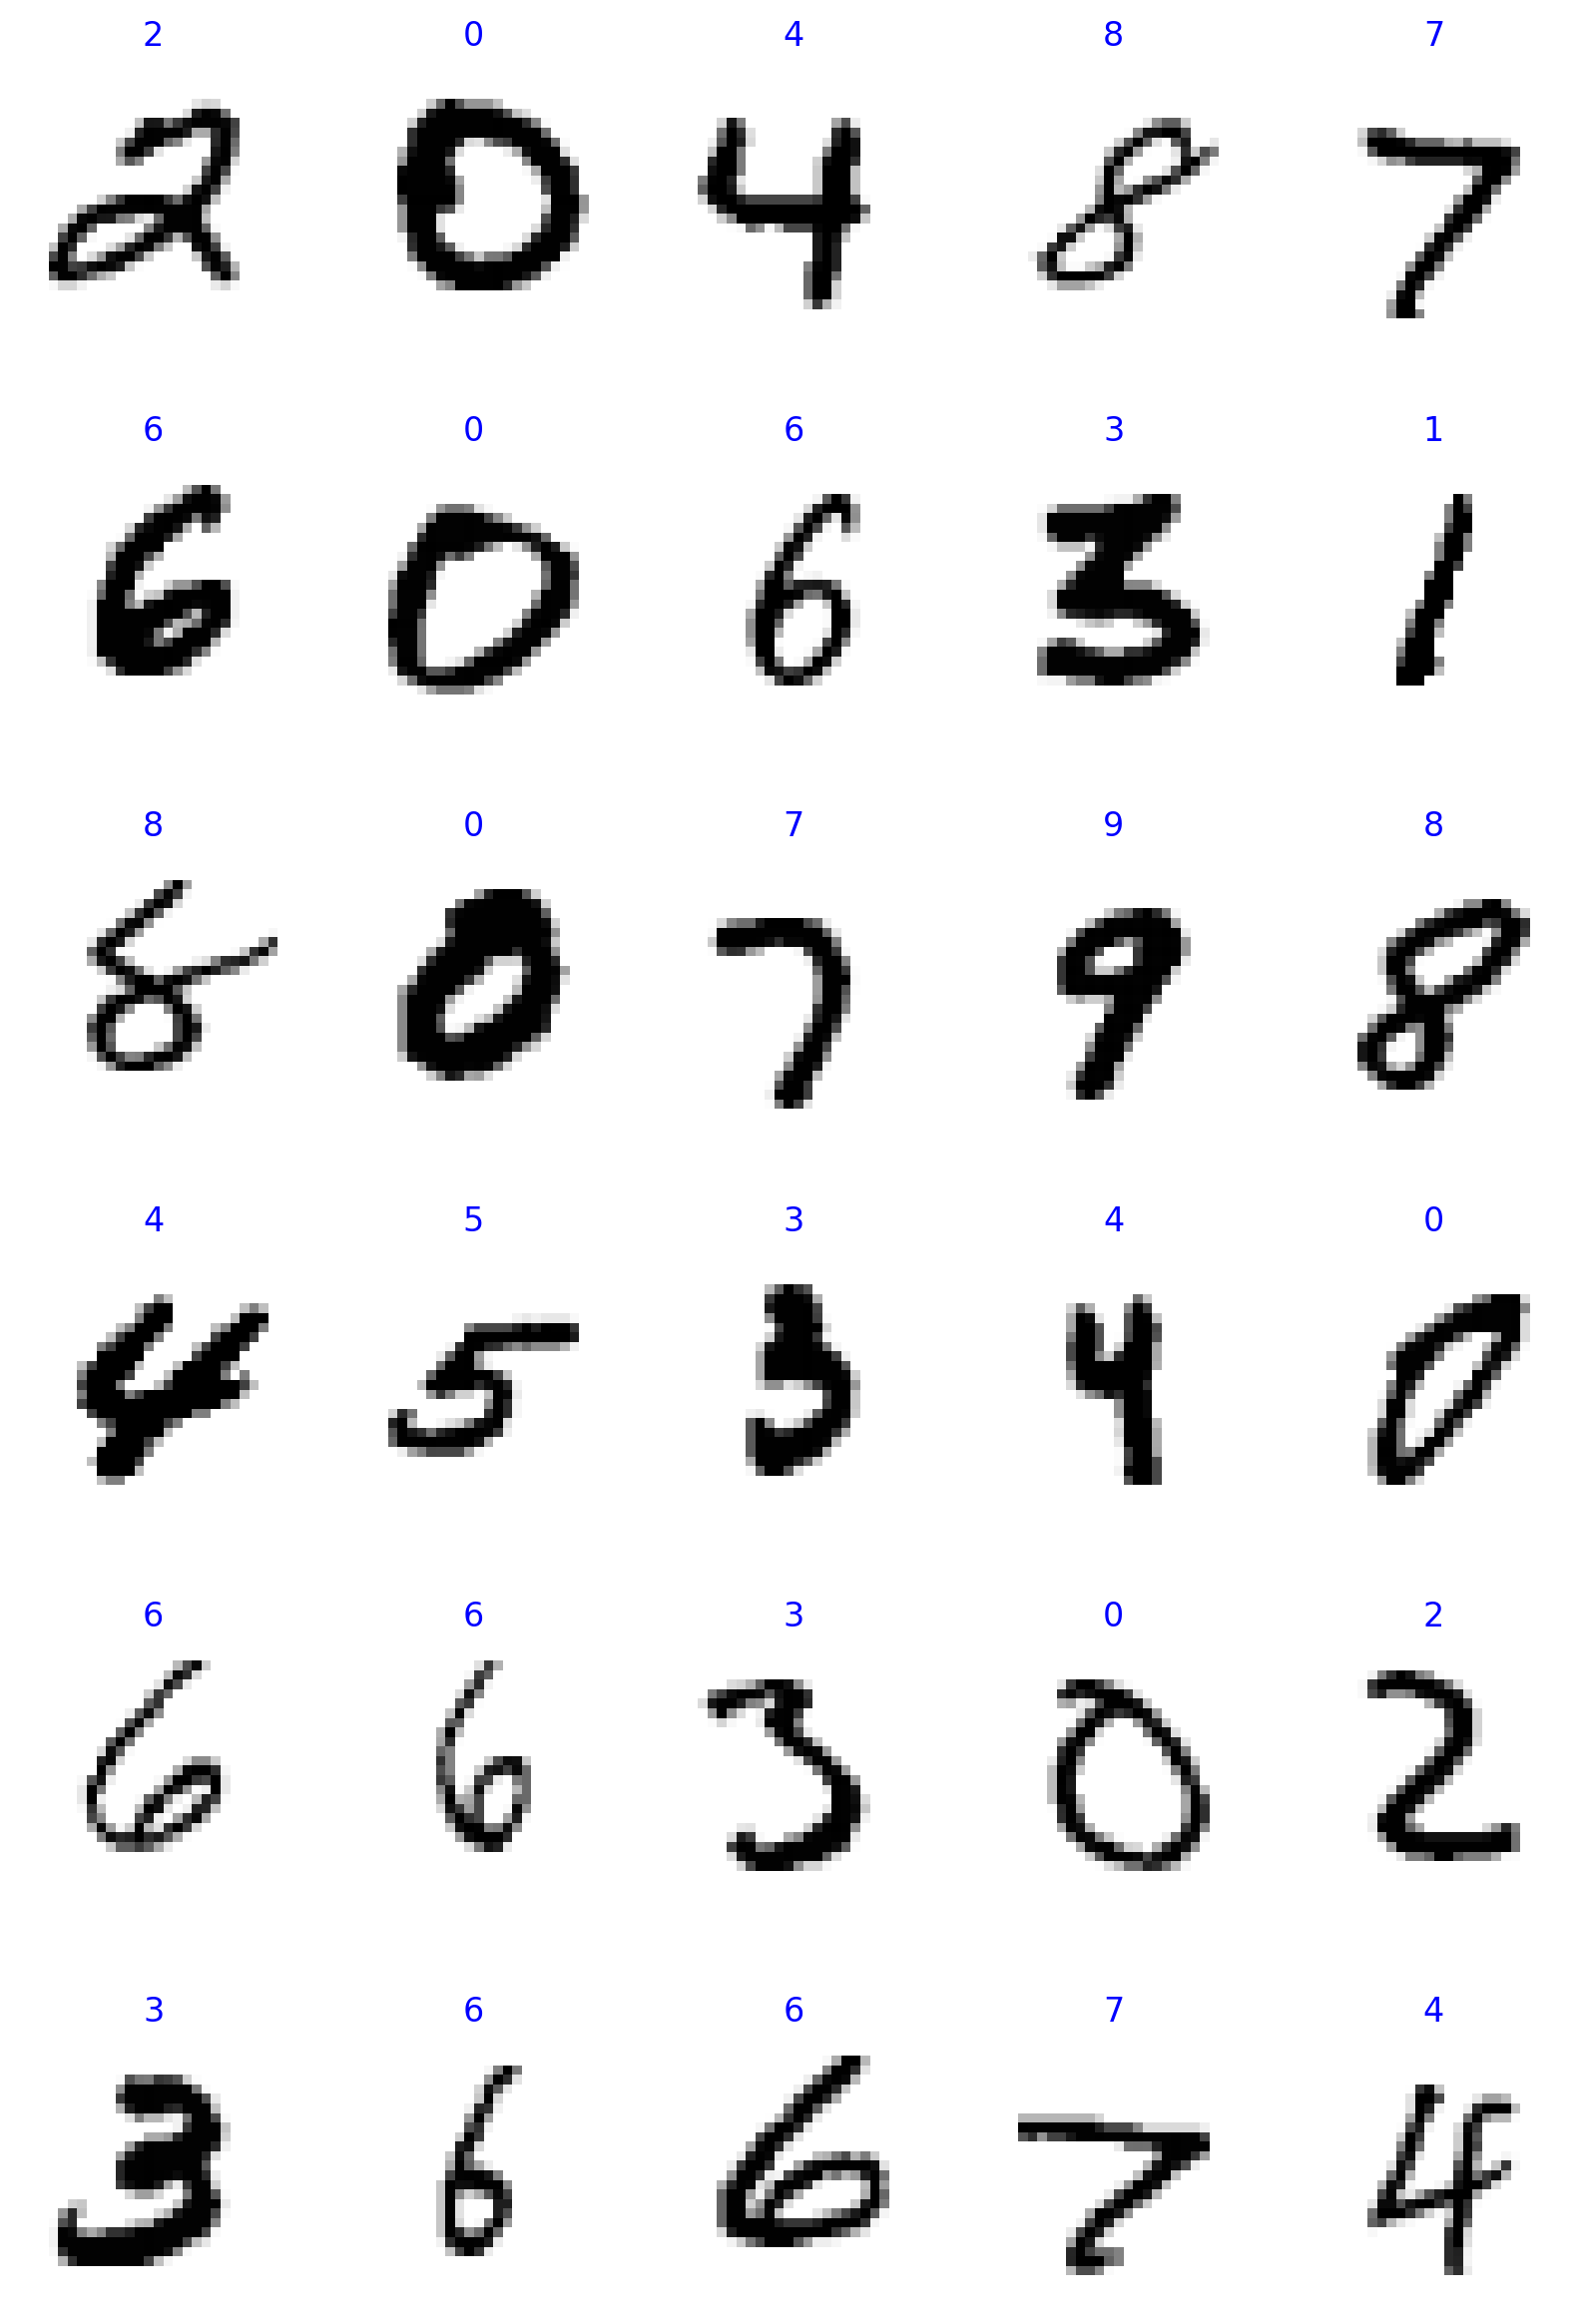

In [271]:
for image_batch, label_batch in testing_batches.take(1):
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()

plt.figure(figsize=(10,15))

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(images[n], cmap = plt.cm.binary)
    plt.title(labels[n], color='blue')
    plt.axis('off')

### Build the Neural Network

In [272]:
tf.keras.backend.clear_session()
rate = 0.2
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (image_size, image_size, 1)),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dropout(rate),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dropout(rate),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

/home/suso/.pyenv/versions/udacity-intro-ml/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Configure the model

In [273]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              

### Loss/Accuracy before training

In [274]:
for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = model.evaluate(image_batch, label_batch)

print(f'\nLoss before training: {loss:,.3f}')
print(f'Accuracy before training: {accuracy:.3%}')

2025-05-24 03:13:26.852616: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-24 03:13:26.856039: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1042 - loss: 2.3685 

Loss before training: 2.357
Accuracy before training: 10.938%


### Train the Neural Network

In [275]:
EPOCHS = 100
PATIENCE = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)
save_best = tf.keras.callbacks.ModelCheckpoint('./best_model.keras',
                                               monitor='val_loss',
                                               save_best_only=True)
history = model.fit(training_batches, epochs = EPOCHS, callbacks=[early_stopping, save_best], validation_data=testing_batches)

Epoch 1/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8037 - loss: 0.6366 - val_accuracy: 0.9553 - val_loss: 0.1470
Epoch 2/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9432 - loss: 0.1874 - val_accuracy: 0.9683 - val_loss: 0.1029
Epoch 3/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9579 - loss: 0.1379 - val_accuracy: 0.9726 - val_loss: 0.0871
Epoch 4/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9656 - loss: 0.1140 - val_accuracy: 0.9756 - val_loss: 0.0793
Epoch 5/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9687 - loss: 0.1023 - val_accuracy: 0.9744 - val_loss: 0.0817
Epoch 6/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9728 - loss: 0.0867 - val_accuracy: 0.9739 - val_loss: 0.0823
Epoch 7/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9767 - loss: 0.0743 - val_accuracy: 0.9770 - val_loss: 0.0802
Epoch 8/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9779 - loss: 0.0710 - val_accu

### Model Training Performance

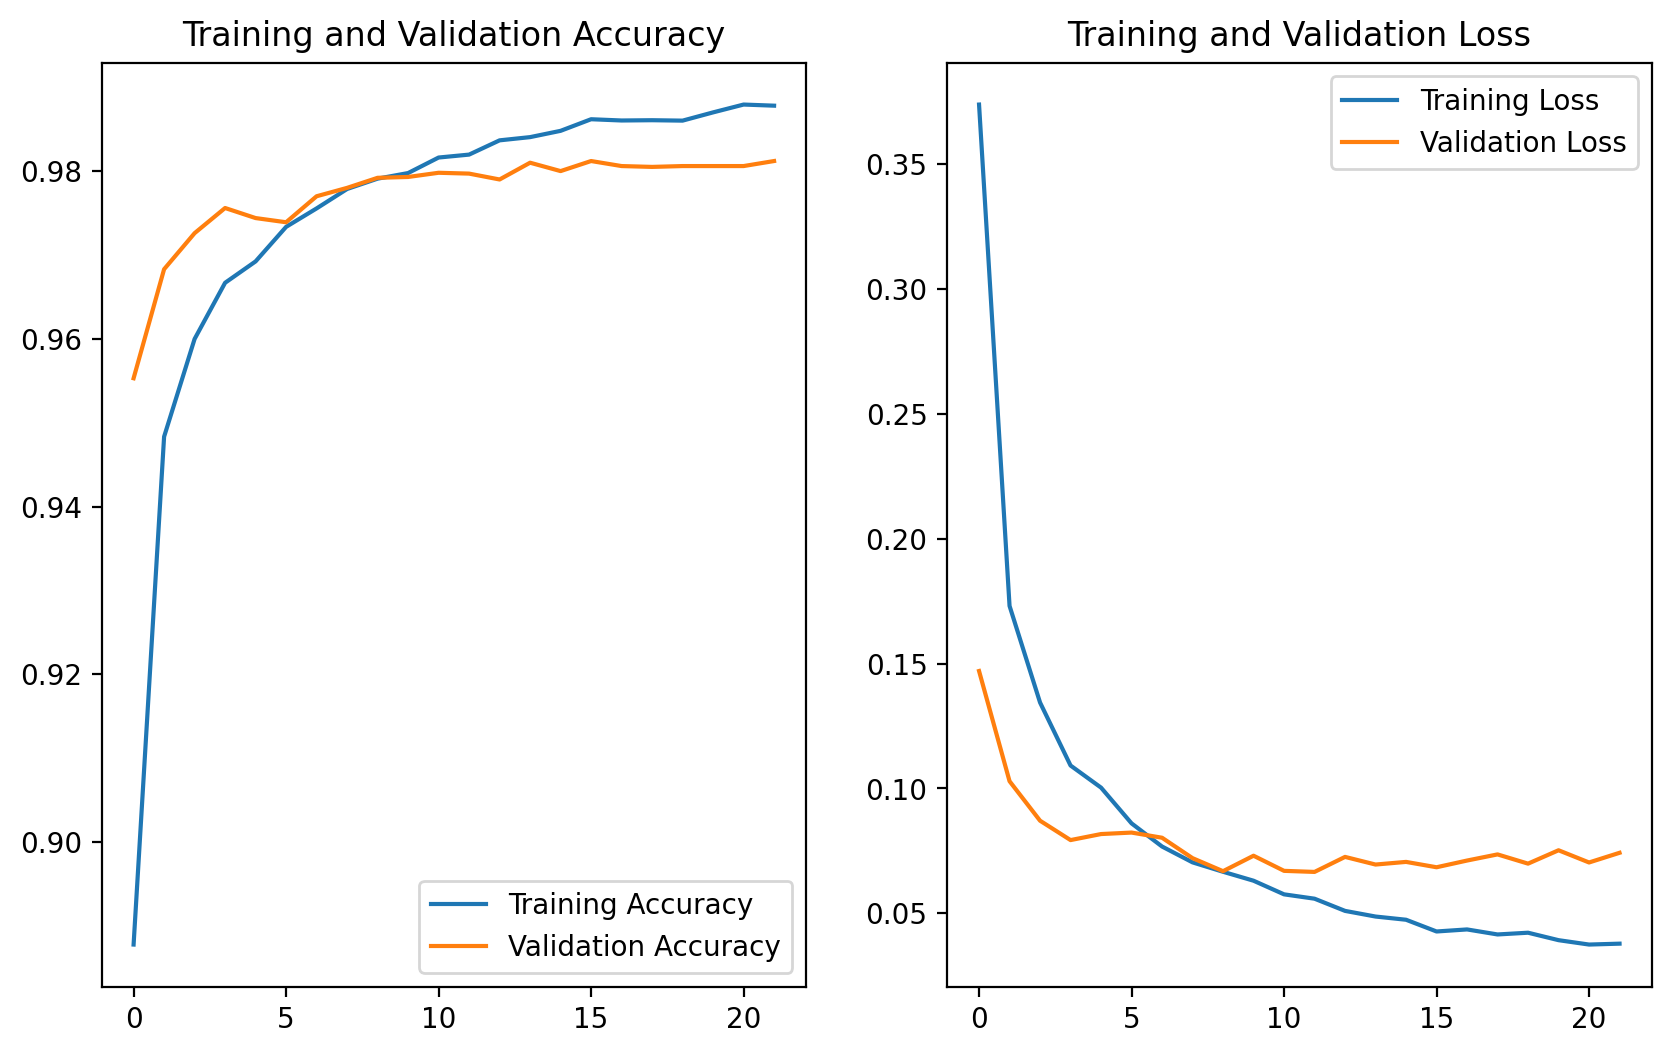

In [276]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Loss/Accuracy after training

In [277]:
for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = model.evaluate(image_batch, label_batch)

print(f'\nLoss after training: {loss:,.3f}')
print(f'Accuracy after training: {accuracy:.3%}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.0018    

Loss after training: 0.002
Accuracy after training: 100.000%


In [278]:
loss, accuracy = model.evaluate(testing_batches)

print(f'\nLoss on the TEST Set: {loss:,.3f}')
print(f'Accuracy on the TEST Set: {accuracy:.3%}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9816 - loss: 0.0664

Loss on the TEST Set: 0.074
Accuracy on the TEST Set: 98.120%


### Prediction

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


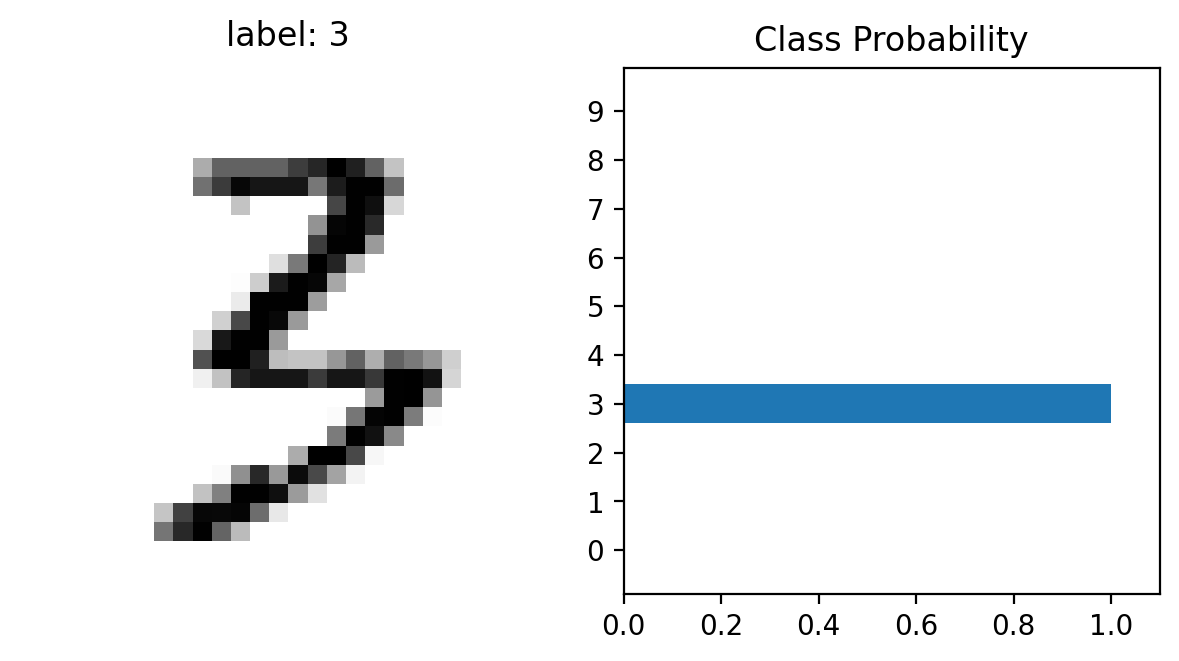

In [279]:
for image_batch, label_batch in testing_batches.take(4):
    ps = model.predict(image_batch)
    first_image = image_batch.numpy().squeeze()[0]
    label = label_batch.numpy()[0]
  
  
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.set_title(f'label: {label}')
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(10), ps[0])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()